In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from IPython.display import Image
from scipy.stats import spearmanr


# Le Basi di Neutron Monitor disponibili per questo esercizio

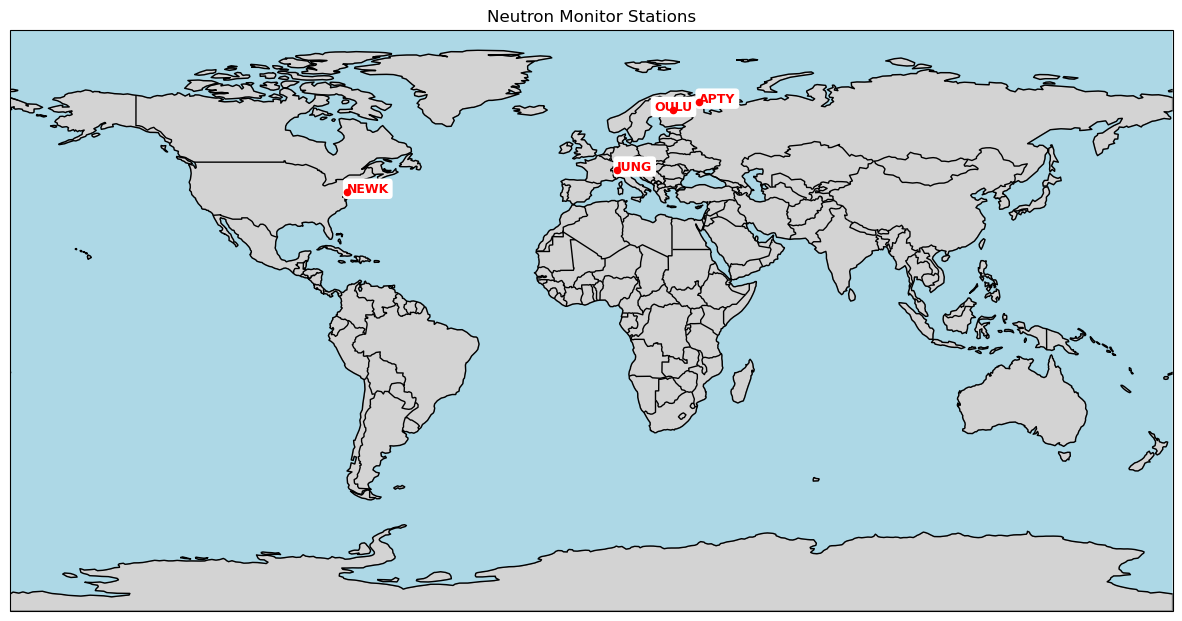

In [2]:
Image(filename='figures/nm_lag.png', width=800, height=800)

In [3]:
# Define the file path
csv_file_path = 'neutron_monitor_stations.csv'
df = pd.read_csv(csv_file_path)

station_codes = ['OULU', 'APTY', 'JUNG','NEWK']

filtered_df = df[df['Station Code'].isin(station_codes)]
filtered_df

,Station Code,Location,Altitude (m),Cutoff Rigidity (GV),Latitude (°),Longitude (°)
1,APTY,"Apatity, Russia",177,0.65,67.57,33.40
15,JUNG,"Jungfraujoch, Switzerland",3475,4.46,46.55,7.98
25,NEWK,"Newark, Delaware, USA",30,2.40,39.68,-75.75
28,OULU,"Oulu, Finland",15,0.81,65.01,25.47


## Seleziona una base

In [4]:
base1 = 'OULU'

## Modulazione solare
- Il Sole emette un vento solare, un flusso di particelle cariche che viaggiano nello spazio. Questo vento crea una sorta di "scudo" attorno al Sistema Solare, che influenza (o "modula") i raggi cosmici galattici (GCR) che provengono dall'esterno del Sistema Solare.

## Potenziale di modulazione ($\phi$)
- Il potenziale di modulazione $\phi$ è un parametro che quantifica l'intensità dello "scudo" solare sui raggi cosmici galattici (GCR). Rappresenta, in pratica, l'energia che un raggio cosmico perde a causa dell'interazione con il vento solare e il campo magnetico eliosferico mentre viaggia verso la Terra.

### Come funziona?
- Quando il Sole è molto attivo, il vento solare e il campo magnetico sono più forti, aumentando il valore di $\phi$. Questo significa che i GCR perdono più energia, e quindi solo quelli più energetici riescono a raggiungere la Terra.  
- Durante un minimo solare, $\phi$ è basso e meno energia viene persa, quindi una quantità maggiore di GCR (compresi quelli meno energetici) riesce ad arrivare.

### Valori tipici
- Il potenziale $\phi$ è espresso in unità di energia (tipicamente in megavolt, MV):
  - **Minimo solare**: $\phi \approx 300-400\ \text{MV}$ (modulazione debole).
  - **Massimo solare**: $\phi$ può superare i $1000\ \text{MV}$ (modulazione forte).

## Force field (campo di forza)
- È una rappresentazione matematica dell'effetto di questa modulazione solare. Più il vento solare è intenso, più forte è il "campo di forza" che respinge o devia i raggi cosmici galattici prima che raggiungano la Terra.  
- Questo modello ci permette, se conosciamo il **LIS** (Local Interstellar Spectrum, ovvero il flusso galattico non modulato), alcuni parametri come la massa e la carica della particella (GCR), e il potenziale di modulazione $\phi$, di stimare il flusso modulato che raggiunge il Sistema Solare interno.


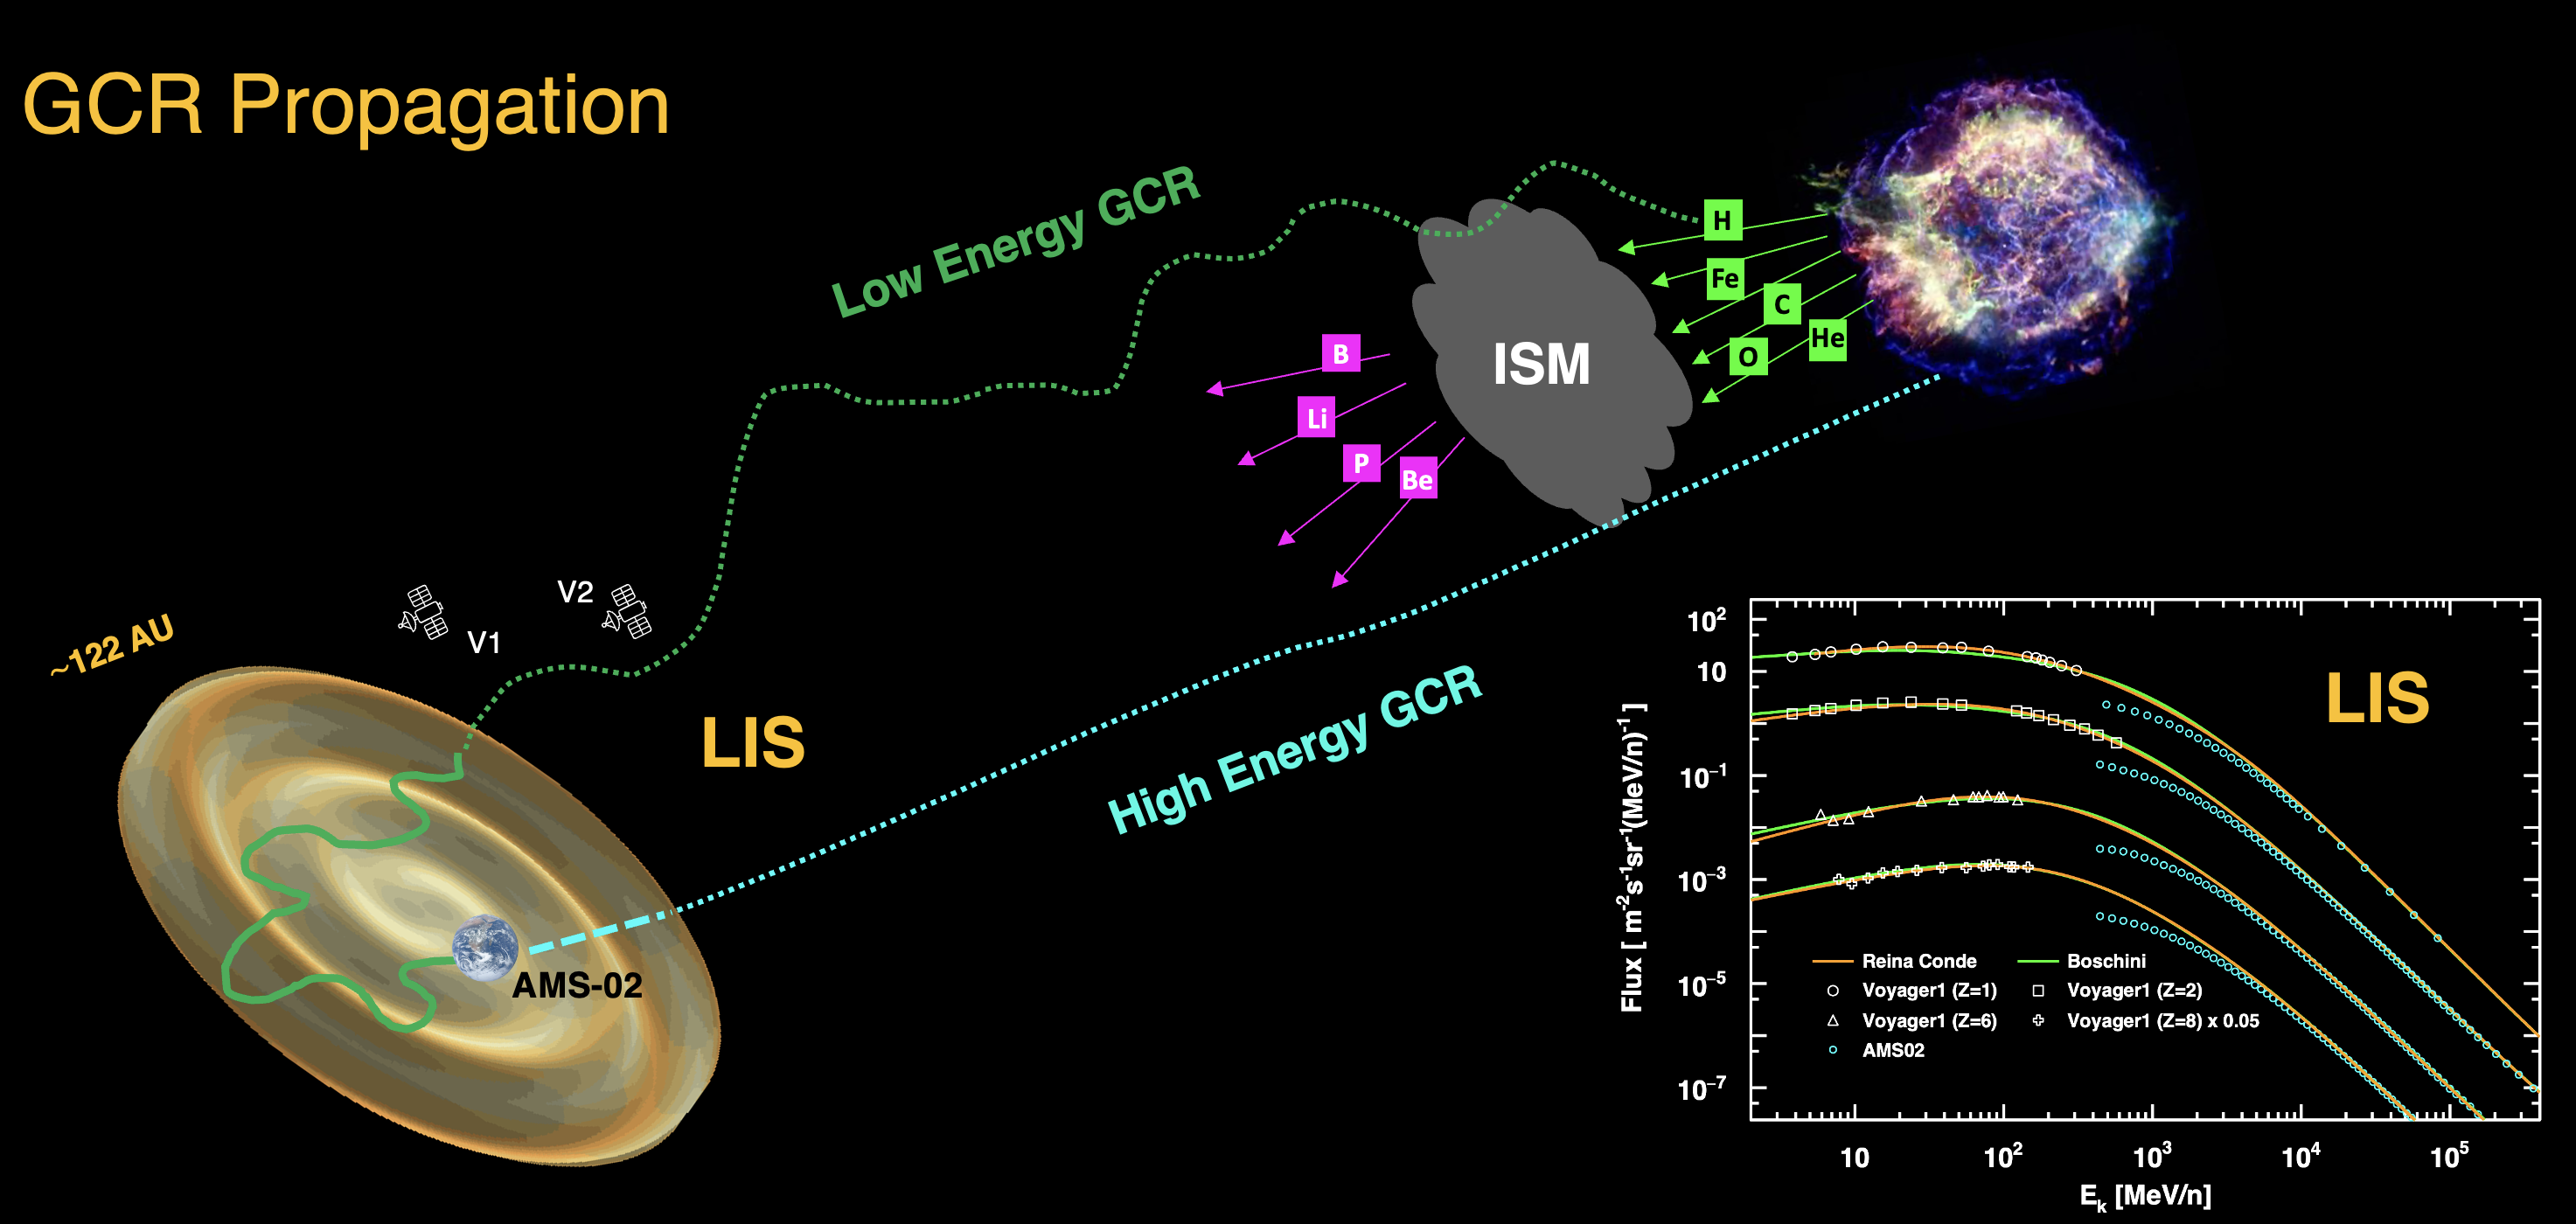

In [5]:
Image(filename='figures/mod.png', width=800, height=800)

Estrazione rate di conteggi [Counts/s] per le basi selezionate

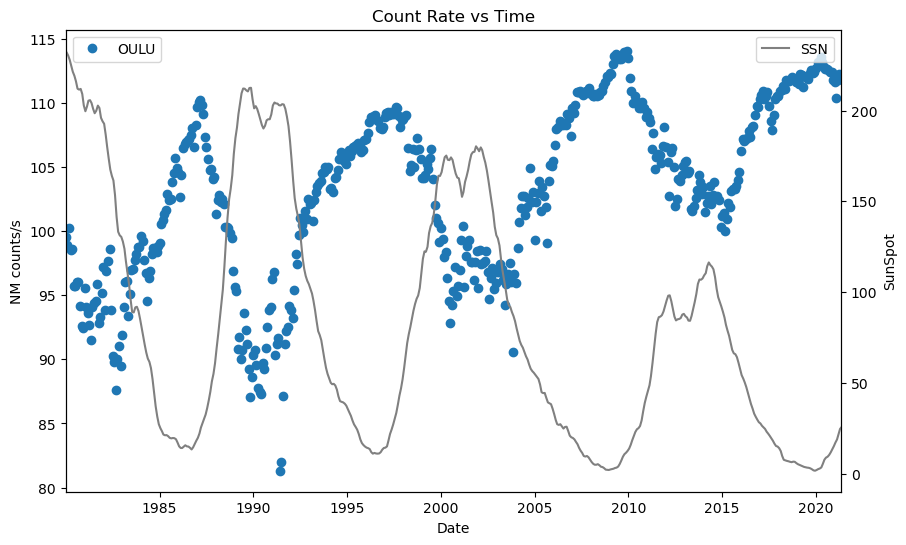

In [6]:


data1 = pd.read_csv(f'NM_basi_ex1/{base1}.csv', header=None, names=['Date', 'Count Rate'], skiprows=1)

# Convert fraction of the year to datetime
data1['Date'] = pd.to_datetime(data1['Date'], format='%Y') + pd.to_timedelta((data1['Date'] % 1) * 365, unit='D')

# Read the CSV file as a pandas DataFrame
data = pd.read_csv('SunSpot.csv')

# Convert the 'datetime' column to datetime objects
data['datetime'] = pd.to_datetime(data['datetime'])

# Create an interpolation function for SSN value
ssn = interp1d(data['datetime'].astype(np.int64), data['SSN value'], fill_value="extrapolate")

# # Determine the x-axis range
min_date = data1['Date'].min()
max_date = data1['Date'].max()


# Plot the data
fig, ax1 = plt.subplots(figsize=(10, 6))
# remove grid lines in the canvas
plt.grid(False)


ax1.plot(data1['Date'], data1['Count Rate'], marker='o', linestyle='', label=f'{base1}')

#interp data1['Date'] and data1['Count Rate'] 

base1_counts = interp1d(data1['Date'].astype(np.int64), data1['Count Rate'], fill_value="extrapolate")


ax1.set_xlabel('Date')
ax1.set_ylabel('NM counts/s')
ax1.set_title('Count Rate vs Time')
ax1.legend(loc='upper left')
ax1.set_xlim([min_date, max_date])

# Create a second y-axis to plot SSN
ax2 = ax1.twinx()

ax2.plot(data['datetime'], data['SSN value'], color='gray', label='SSN')
ax2.set_ylabel('SunSpot')
ax2.legend(loc='upper right')
ax2.set_xlim([min_date, max_date])

plt.show()


###  Come atteso il numero di SSN (indicatore di attività solare) e i conteggi di NM sono anticorrelati!

### Dalle serie stotiche (dati "raw") di una serie di basi di Neutron Monitor è possibile ricavare una stima del potenziale di modulazione  $\phi$

- from Väisänen, Usoskin, Kähkönen, Koldobskiy, Mursula: Updated heliospheric modulation potential of cosmic rays and station-specific scaling factors for 1964-2021

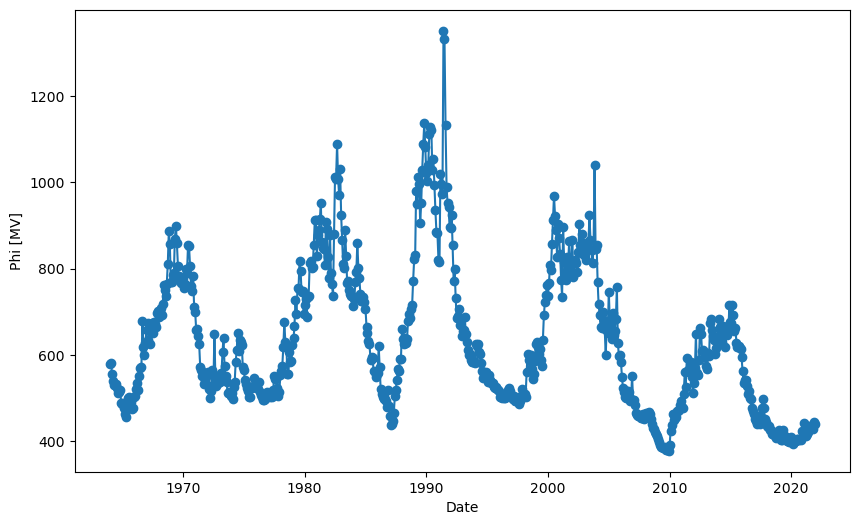

In [7]:
# Read the CSV file, skipping the first row and using semicolon as the delimiter
phi_data = pd.read_csv('Monthlyphi.csv', skiprows=1, sep=';', names=['Year', 'Month', 'Fractional Year', 'Phi Value'])

# Ensure the columns are of the correct data type
phi_data['Year'] = phi_data['Year'].astype(int)
phi_data['Month'] = phi_data['Month'].astype(int)
phi_data['Fractional Year'] = phi_data['Fractional Year'].astype(float)
phi_data['Phi Value'] = phi_data['Phi Value'].astype(float)

# Convert the 'Year' and 'Month' columns to datetime objects
phi_data['Date'] = pd.to_datetime(phi_data[['Year', 'Month']].assign(DAY=1))

# Plot the data
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(phi_data['Date'], phi_data['Phi Value'], marker='o', linestyle='-')
ax.set_xlabel('Date')
ax.set_ylabel('Phi [MV]')
plt.show()

# Define an interpolation function
phi = interp1d(phi_data['Date'].astype(np.int64), phi_data['Phi Value'], fill_value="extrapolate")




### Questa è la serie storica (mensile) del potenziale di modulazione $\phi$ ottenuta proprio dai conteggi di diverse basi di Neutron Monitor

# LIS Protoni - Il Flusso Galattico che ci serve per applicare il modello Force-Field e stimare il flusso modulato dei protoni (GCR)

### combianando dati delle sonde Voyager e dati di AMS-02 e modelli di propagazione galattica ed eliosferica abbiamo un modello per il flusso galattico (costante - LIS) di protoni  

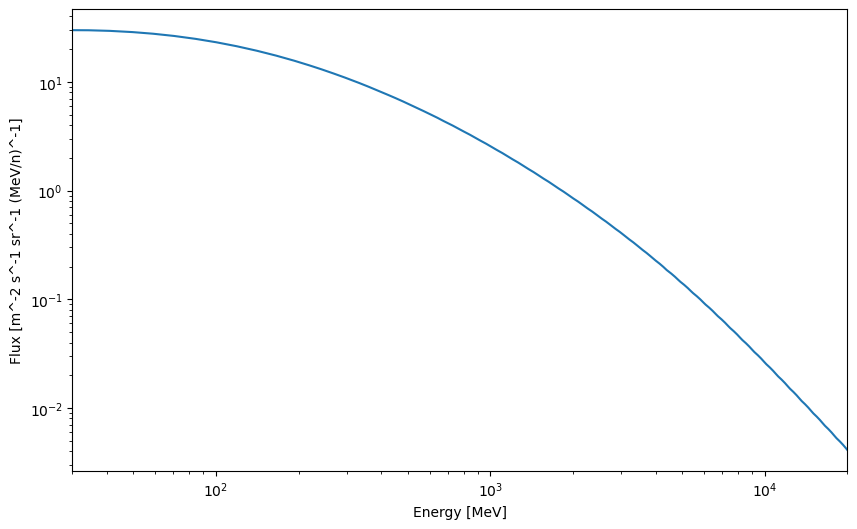

In [8]:
# Read the CSV file as a pandas DataFrame
data = pd.read_csv('LIS.csv')

# Create an interpolation function for LIS flux values
J_lis = interp1d(data['energy[MeV]'], data['Flux'], fill_value="extrapolate")

#plot the lis
fig, ax = plt.subplots(figsize=(10, 6))
# log scale
ax.set_yscale('log')
ax.set_xscale('log')
# energy range
ax.set_xlim([30, 20000])
ax.plot(data['energy[MeV]'], data['Flux'], linestyle='-')
ax.set_xlabel('Energy [MeV]')
ax.set_ylabel('Flux [m^-2 s^-1 sr^-1 (MeV/n)^-1]')
plt.show()


# Il Modello Force-Field - l'equazione

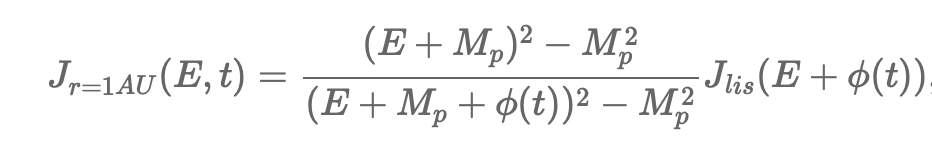

In [9]:
Image(filename='figures/ForceField.png', width=800, height=800)

# Studiare l'effetto della modulazione a diverse energie [MeV]. 
### La modulazione solare è efficace a basse energie (< 3/4 GeV) mentre a più alte energie il campo magnetico eliosferico è troppo poco intenso per modificare significativamente le traiettorie dei raggi cosmici.

## Seleziona un'energia e un periodo temporale di riferimento

In [10]:
start_date = '2000-05-15'
end_date = '2020-06-15'
 
E = 5000 # MeV  


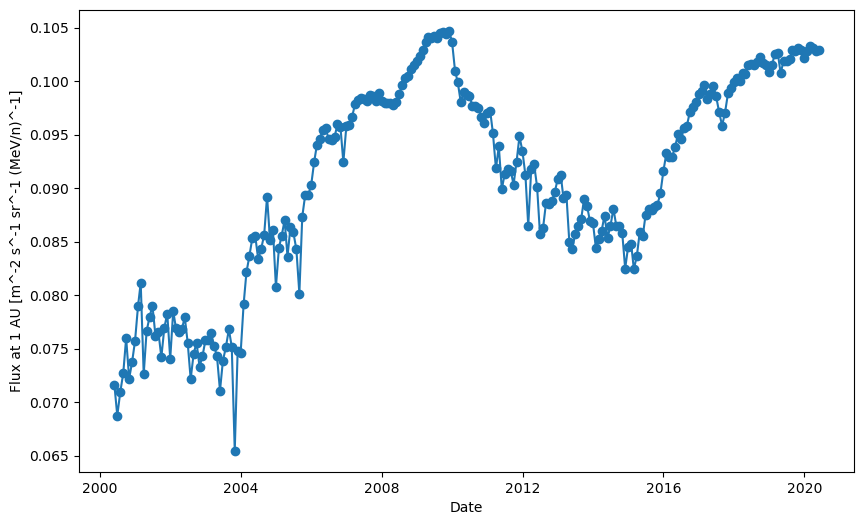

In [11]:
# Proton mass in MeV (constant)
M_p = 938.272  # Proton mass in MeV/c^2

def flux_reconstruction(E, phi, date_range, J_lis):
    """
    Compute the flux at 1 AU using the provided formula.
    
    Parameters:
    E : float
        Energy in MeV.
    phi : function
        An interpolation function for modulation potential values (phi(t)).
    t_index : int
        The index in the phi_values timeseries for the time t of interest.
    J_lis : function
        A function that takes energy (in MeV) as input and returns the LIS flux.
    
    Returns:
    float
        The reconstructed flux at 1 AU.
    """
    # Extract the modulation potential for the given time index
    phi_t = phi(date_range.astype(np.int64))
    
    # Compute the numerator and denominator of the flux formula
    numerator = (E + M_p)**2 - M_p**2
    denominator = (E + M_p + phi_t)**2 - M_p**2
    
    # Compute the flux at 1 AU
    J_r_1AU = (numerator / denominator) * J_lis(E + phi_t)
    
    return J_r_1AU







date_range = pd.date_range(start=start_date, end=end_date, freq='M')


# Compute the flux
flux = flux_reconstruction(E, phi, date_range, J_lis)

#plot the flux
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(date_range, flux, marker='o', linestyle='-')
ax.set_xlabel('Date')
ax.set_ylabel('Flux at 1 AU [m^-2 s^-1 sr^-1 (MeV/n)^-1]')
plt.show()



### Ricostruzione del flusso di protoni all'energia selezionata  
Questa è la ricostruzione del flusso di protoni a una determinata energia, ottenuta applicando il modello **Force-Field**.  

### Il modello **Force-Field** mostra sempre una variazione ciclica del flusso in relazione all'attività solare. Tuttavia, l'effetto della modulazione è meno intenso alle alte energie. Per questo motivo, è utile visualizzare la variazione del flusso rispetto alla media: se l'energia $E$ aumenta, la variazione diventa progressivamente più piccola.


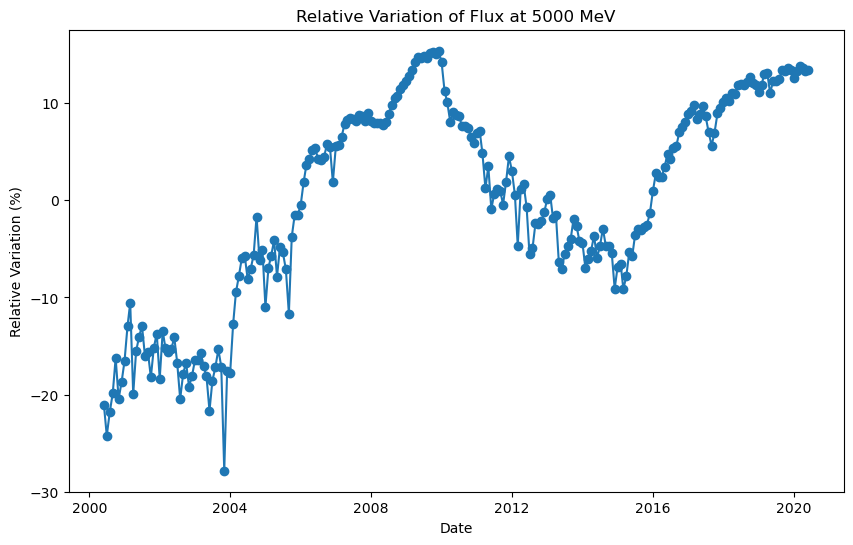

In [12]:
# Calculate the mean of the flux
mean_flux = np.mean(flux)

# Calculate the relative variation with respect to the mean
relative_variation = (flux - mean_flux) / mean_flux * 100

# Plot the relative variation
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(date_range, relative_variation, marker='o', linestyle='-')
ax.set_xlabel('Date')
ax.set_ylabel('Relative Variation (%)')
ax.set_title(f'Relative Variation of Flux at {E} MeV')
plt.show()

## Domanda 
- ripeti il codice con diverse energie per osservare come dimminuisce la variazione (%) rispetto alla media  

## Time Lag tra Sunspot Number e Conteggi di Neutron Monitor o Flussi Spaziali

Il **time lag** (ritardo temporale) tra il numero di macchie solari (**sunspot number**) e i conteggi dei neutron monitor o i flussi misurati nello spazio si riferisce al fatto che i cambiamenti nell'attività solare non si riflettono immediatamente nei raggi cosmici osservati.

### Perché c'è un ritardo?  
Quando il numero di macchie solari aumenta, il Sole diventa più attivo e il vento solare e il suo campo magnetico si intensificano. Tuttavia, l'effetto sui raggi cosmici richiede tempo per manifestarsi per due motivi principali:
1. **Propagazione lenta del vento solare**:  
   Il vento solare e il campo magnetico impiegano giorni o settimane per diffondersi nello spazio e influenzare i raggi cosmici (velocità del vento solare circa 400 km/s).

2. **Inerzia del sistema**:  
   Il comportamento dei raggi cosmici è influenzato non solo dalle condizioni attuali del Sole, ma anche dall'accumulo delle condizioni passate.



### Seleziona un set di possibili delay (in mesi)  
- Calcola la correlazione (attraverso il coefficiente di Spearman) tra il numero di SSN (Sunspot Number) e i conteggi della base Neutron Monitor scelta. 
- Verifica come la correlazione evolve nel tempo e raggiunge un massimo per uno specifico delay.

In [13]:
print(f"La base selezionata è : {base1}")


La base selezionata è : OULU


## seleziona un set di possibili lag (in mesi) e un periodo temporale sul quale calcolare questa correlazione tra 1980 - 2021

In [14]:
# esempio 
delays = (0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 14, 18) # in mesi
start_date = '2008-05-15'
end_date = '2020-06-15'

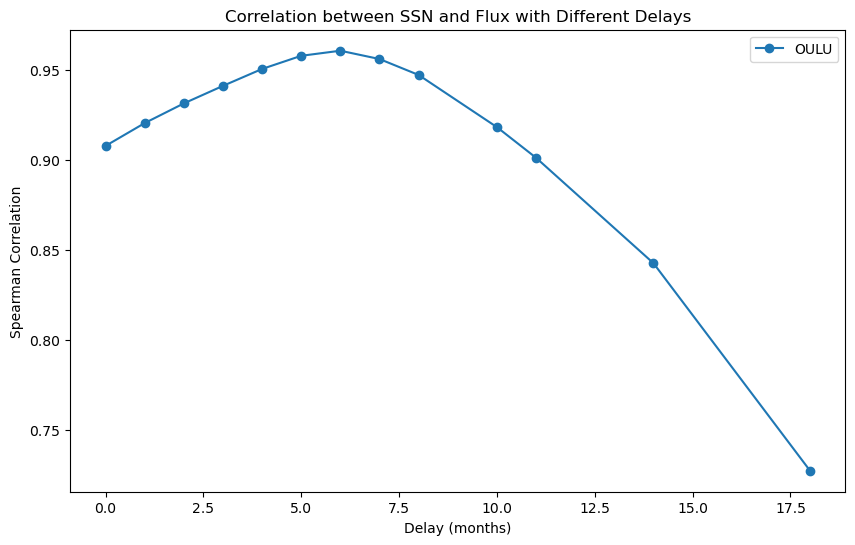

In [15]:
def calculate_correlation_with_delay(delay_months, base):
    delayed_ssn_values = ssn((date_range - pd.DateOffset(months=delay_months)).astype(np.int64))    
    # Calculate the Spearman correlation
    correlation, _ = spearmanr(delayed_ssn_values, base)
    
    return abs(correlation)



date_range = pd.date_range(start=start_date, end=end_date, freq='M')

correlations_1 = [calculate_correlation_with_delay(delay, base1_counts(date_range.astype(np.int64))) for delay in delays]

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(delays, correlations_1, marker='o', linestyle='-')
ax.legend(loc='upper right', labels=[base1])
ax.set_xlabel('Delay (months)')
ax.set_ylabel('Spearman Correlation')
ax.set_title('Correlation between SSN and Flux with Different Delays')
plt.show()

In [16]:
delay_interp_1 = interp1d(delays, correlations_1, kind='cubic')
finer_delays = np.linspace(0, max(delays), num=100)
finer_correlations_1 = delay_interp_1(finer_delays)

# Find the max correlation and corresponding delay
max_correlation1 = np.max(finer_correlations_1)
max_delay1 = finer_delays[np.argmax(finer_correlations_1)]

print(f"Correlazione massuma: {max_correlation1:.2f} per un delat di {max_delay1:.2f} mesi")

Correlazione massuma: 0.96 per un delat di 5.82 mesi


## Domanda
- Quale base avete scelto per determinare il lag?
- Quanto vale la stima del lag?
- Il lag temporale varia se selezionate una base diversa?
- Il lag temporale varia se si considera un periodo diverso?  
  (Consiglio: valutate relativamente ai cicli solari ciclo 23 e ciclo 24)

### Date dei Cicli Solari:
- **Ciclo 23**: Inizio nel 1996, fine nel 2008.
- **Ciclo 24**: Inizio nel 2008, fine nel 2020
